In [1]:
import pandas as pd
import devkit.api as dk
import numpy as np
%matplotlib inline

In [111]:
# options = pd.read_csv(r"C:\Users\youlin\Desktop\option_data\option.csv")
options = pd.read_csv(r"C:\Users\youlin\Desktop\option_data\Out-of-sample_options.csv")

In [112]:
options = options[['date', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume', 'open_interest','impl_volatility', 'delta',
       'gamma', 'vega', 'theta']].copy()

In [113]:
options = options.dropna().drop(['volume'], axis=1)

In [114]:
# underlying = pd.read_csv(r"C:\Users\youlin\Desktop\option_data\underlying.csv")
underlying = pd.read_csv(r"C:\Users\youlin\Desktop\option_data\Out-of-sample_underlying.csv")
underlying = underlying[['date', 'low', 'high', 'open', 'close', 'volume', 'return']].copy()

In [115]:
options = options.merge(underlying, how='inner', on=['date'])
options['date'] = options['date'].apply(lambda x: dk.char2datetime(str(x),format="%Y%m%d"))
options['exdate'] = options['exdate'].apply(lambda x: dk.char2datetime(str(x),format="%Y%m%d"))
options['strike_price'] = options['strike_price'].apply(lambda x: x / 1000)
options['days_to_maturity'] = options['exdate'] - options['date']
options['atm'] = np.abs(options['close'] / options['strike_price'] - 1) # 平值率 该值越小 越接近平值期权
# 对于某一天存在多个相同类型的期权 选择到期日最长、平值率最小的期权
options = options.sort_values(['date', 'cp_flag', 'days_to_maturity', 'atm'], ascending=[True, True, False, True])
options = options.drop_duplicates(['date', 'cp_flag'], keep='first') 

In [116]:
close = options[['date', 'close']].copy().drop_duplicates().reset_index().drop('index', axis=1)
for  i in close.index:
    if i >= 20:
        close.loc[i, 'std'] = close.loc[i-20 : i, 'close'].std()
        close.loc[i, 'mean'] = close.loc[i-20 : i, 'close'].mean()
        close.loc[i, 'upper'] = close.loc[i, 'mean'] + 2.5 * close.loc[i, 'std']
        close.loc[i, 'lower'] = close.loc[i, 'mean'] - 2.5 * close.loc[i, 'std'] 
close = close.dropna().reset_index().drop(['index'], axis=1)

In [117]:
options1 = options.set_index(['date', 'cp_flag'])

In [118]:
margin = 0.4
close1 = close.copy()
end_id = len(close1) - 1
for i in close1.index:
    date = close1.loc[i, 'date']
    if i == 0: # 初始持仓
        close1.loc[i, 'balance'] = 100 # 账户余额 初始为100
        close1.loc[i, 'position'] = 0 # 初始头寸
        if close1.loc[i, 'close'] > close1.loc[i, 'upper']: # 多头信号 卖出看跌期权
            option_price = options1.loc[str(date), 'P']['best_offer']
            close1.loc[i, 'signal'] = "-p"
            close1.loc[i, 'position'] = np.floor(close1.loc[i, 'balance'] / (margin * close1.loc[i, 'close']))
            close1.loc[i, 'amount'] = option_price * close1.loc[i, 'position']
            close1.loc[i, 'balance'] = close1.loc[i, 'balance'] + close1.loc[i, 'amount']
        elif close1.loc[i, 'close'] < close1.loc[i, 'lower']: # 空头信号 卖出看涨期权
            option_price = options1.loc[str(date), 'C']['best_offer']
            close1.loc[i, 'signal'] = "-c"
            close1.loc[i, 'amount'] = option_price
            close1.loc[i, 'position'] = np.floor(close1.loc[i, 'balance'] / (margin * close1.loc[i, 'close']))
            close1.loc[i, 'amount'] = option_price * close1.loc[i, 'position']
            close1.loc[i, 'balance'] = close1.loc[i, 'balance'] + close1.loc[i, 'amount']
        else:
            close1.loc[i, 'signal'] = "No signal"
            close1.loc[i, 'amount'] = 0
            close1.loc[i, 'position'] = 0
    else:
        if close1.loc[i-1, 'position'] == 0: # 空仓时
            if close1.loc[i, 'close'] > close1.loc[i, 'upper']: # 多头信号 卖出看跌期权
                option_price = options1.loc[str(date), 'P']['best_offer']
                close1.loc[i, 'signal'] = "-p"
                close1.loc[i, 'position'] = np.floor(close1.loc[i-1, 'balance'] / (margin * close1.loc[i, 'close']))
                close1.loc[i, 'amount'] = option_price * close1.loc[i, 'position']
                close1.loc[i, 'balance'] = close1.loc[i-1, 'balance'] + close1.loc[i, 'amount']
            elif  close1.loc[i, 'close'] < close1.loc[i, 'lower']: # 空头信号 卖出看涨期权
                option_price = options1.loc[str(date), 'C']['best_offer']
                close1.loc[i, 'signal'] = "-c"
                close1.loc[i, 'amount'] = option_price
                close1.loc[i, 'position'] = np.floor(close1.loc[i-1, 'balance'] / (margin * close1.loc[i, 'close']))
                close1.loc[i, 'amount'] = option_price * close1.loc[i, 'position']
                close1.loc[i, 'balance'] = close1.loc[i-1, 'balance'] + close1.loc[i, 'amount']
            else: # 没有出现任何信号
                close1.loc[i, 'signal'] = "No signal"
                close1.loc[i, 'position'] = 0
                close1.loc[i, 'amount'] = 0
                close1.loc[i, 'balance'] = close1.loc[i-1, 'balance'] 
        else: # 已经有持仓时
            if close1.loc[i-1, 'signal'] == "-p":
                if close1.loc[i, 'close'] <= close1.loc[i, 'mean'] or i == end_id: # 价格回落至中轨线触发卖出信号
                    option_price = options1.loc[str(date), 'P']['best_bid']
                    close1.loc[i, 'signal'] = "p"
                    close1.loc[i, 'amount'] = -close1.loc[i-1, 'position'] * option_price
                    close1.loc[i, 'position'] = 0
                    close1.loc[i, 'balance'] = close1.loc[i-1, 'balance'] + close1.loc[i, 'amount']
                else:
                    close1.loc[i, 'signal'] = close1.loc[i-1, 'signal']
                    close1.loc[i, 'position'] = close1.loc[i-1, 'position']
                    close1.loc[i, 'amount'] = close1.loc[i-1, 'amount'] 
                    close1.loc[i, 'balance'] = close1.loc[i-1, 'balance'] 
            if close1.loc[i-1, 'signal'] == "-c":
                if close1.loc[i-1, 'close'] >= close1.loc[i, 'mean'] or i == end_id: # 价格上升至中轨线触发卖出信号
                    option_price = options1.loc[str(date), 'C']['best_bid']
                    close1.loc[i, 'signal'] = "c"
                    close1.loc[i, 'amount'] = -close1.loc[i-1, 'position'] * option_price
                    close1.loc[i, 'position'] = 0
                    close1.loc[i, 'balance'] = close1.loc[i-1, 'balance'] + close1.loc[i, 'amount']
                else:
                    close1.loc[i, 'signal'] = close1.loc[i-1, 'signal']
                    close1.loc[i, 'position'] = close1.loc[i-1, 'position']
                    close1.loc[i, 'amount'] = close1.loc[i-1, 'amount'] 
                    close1.loc[i, 'balance'] = close1.loc[i-1, 'balance'] 

In [119]:
# 提升杠杆
margin = 0.45
close3 = close.copy()
end_id = len(close3) - 1
for i in close3.index:
    date = close3.loc[i, 'date']
    if i == 0: # 初始持仓
        close3.loc[i, 'balance'] = 100 # 账户余额 初始为100
        close3.loc[i, 'position'] = 0 # 初始头寸
        if close3.loc[i, 'close'] > close3.loc[i, 'upper']: # 多头信号 卖出看跌期权
            option_price = options1.loc[str(date), 'P']['best_offer']
            close3.loc[i, 'signal'] = "-p"
            close3.loc[i, 'position'] = np.floor(close3.loc[i, 'balance'] / (margin * close3.loc[i, 'close']))
            close3.loc[i, 'amount'] = option_price * close3.loc[i, 'position']
            close3.loc[i, 'balance'] = close3.loc[i, 'balance'] + close3.loc[i, 'amount']
        elif close3.loc[i, 'close'] < close3.loc[i, 'lower']: # 空头信号 卖出看涨期权
            option_price = options1.loc[str(date), 'C']['best_offer']
            close3.loc[i, 'signal'] = "-c"
            close3.loc[i, 'amount'] = option_price
            close3.loc[i, 'position'] = np.floor(close3.loc[i, 'balance'] / (margin * close3.loc[i, 'close']))
            close3.loc[i, 'amount'] = option_price * close3.loc[i, 'position']
            close3.loc[i, 'balance'] = close3.loc[i, 'balance'] + close3.loc[i, 'amount']
        else:
            close3.loc[i, 'signal'] = "No signal"
            close3.loc[i, 'amount'] = 0
            close3.loc[i, 'position'] = 0
    else:
        if close3.loc[i-1, 'position'] == 0: # 空仓时
            if close3.loc[i, 'close'] > close3.loc[i, 'upper']: # 多头信号 卖出看跌期权
                option_price = options1.loc[str(date), 'P']['best_offer']
                close3.loc[i, 'signal'] = "-p"
                close3.loc[i, 'position'] = np.floor(close3.loc[i-1, 'balance'] / (margin * close3.loc[i, 'close']))
                close3.loc[i, 'amount'] = option_price * close3.loc[i, 'position']
                close3.loc[i, 'balance'] = close3.loc[i-1, 'balance'] + close3.loc[i, 'amount']
            elif  close3.loc[i, 'close'] < close3.loc[i, 'lower']: # 空头信号 卖出看涨期权
                option_price = options1.loc[str(date), 'C']['best_offer']
                close3.loc[i, 'signal'] = "-c"
                close3.loc[i, 'amount'] = option_price
                close3.loc[i, 'position'] = np.floor(close3.loc[i-1, 'balance'] / (margin * close3.loc[i, 'close']))
                close3.loc[i, 'amount'] = option_price * close3.loc[i, 'position']
                close3.loc[i, 'balance'] = close3.loc[i-1, 'balance'] + close3.loc[i, 'amount']
            else: # 没有出现任何信号
                close3.loc[i, 'signal'] = "No signal"
                close3.loc[i, 'position'] = 0
                close3.loc[i, 'amount'] = 0
                close3.loc[i, 'balance'] = close3.loc[i-1, 'balance'] 
        else: # 已经有持仓时
            if close3.loc[i-1, 'signal'] == "-p":
                if close3.loc[i, 'close'] <= close3.loc[i, 'mean'] or i == end_id: # 价格回落至中轨线触发卖出信号
                    option_price = options1.loc[str(date), 'P']['best_bid']
                    close3.loc[i, 'signal'] = "p"
                    close3.loc[i, 'amount'] = -close3.loc[i-1, 'position'] * option_price
                    close3.loc[i, 'position'] = 0
                    close3.loc[i, 'balance'] = close3.loc[i-1, 'balance'] + close3.loc[i, 'amount']
                else:
                    close3.loc[i, 'signal'] = close3.loc[i-1, 'signal']
                    close3.loc[i, 'position'] = close3.loc[i-1, 'position']
                    close3.loc[i, 'amount'] = close3.loc[i-1, 'amount'] 
                    close3.loc[i, 'balance'] = close3.loc[i-1, 'balance'] 
            if close3.loc[i-1, 'signal'] == "-c":
                if close3.loc[i-1, 'close'] >= close3.loc[i, 'mean'] or i == end_id: # 价格上升至中轨线触发卖出信号
                    option_price = options1.loc[str(date), 'C']['best_bid']
                    close3.loc[i, 'signal'] = "c"
                    close3.loc[i, 'amount'] = -close3.loc[i-1, 'position'] * option_price
                    close3.loc[i, 'position'] = 0
                    close3.loc[i, 'balance'] = close3.loc[i-1, 'balance'] + close3.loc[i, 'amount']
                else:
                    close3.loc[i, 'signal'] = close3.loc[i-1, 'signal']
                    close3.loc[i, 'position'] = close3.loc[i-1, 'position']
                    close3.loc[i, 'amount'] = close3.loc[i-1, 'amount'] 
                    close3.loc[i, 'balance'] = close3.loc[i-1, 'balance'] 

In [84]:
margin = 0.2
close2 = close.copy()
for i in close2.index:
    date = close2.loc[i, 'date']
    if i == 0: # 初始持仓
        close2.loc[i, 'balance'] = 100 # 账户余额 初始为100
        close2.loc[i, 'position'] = 0 # 初始头寸
        if close2.loc[i, 'close'] > close2.loc[i, 'upper']: # 多头信号 卖出看跌期权
            option_price = options1.loc[str(date), 'P']['best_offer']
            close2.loc[i, 'signal'] = "-p"
            close2.loc[i, 'position'] = np.floor(close2.loc[i, 'balance'] / (margin * close2.loc[i, 'close']))
            close2.loc[i, 'amount'] = option_price * close2.loc[i, 'position']
            close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] + close2.loc[i, 'amount']
        elif close2.loc[i, 'close'] < close2.loc[i, 'lower']: # 空头信号 卖出看涨期权
            option_price = options1.loc[str(date), 'C']['best_offer']
            close2.loc[i, 'signal'] = "-c"
            close2.loc[i, 'amount'] = option_price
            close2.loc[i, 'position'] = np.floor(close2.loc[i, 'balance'] / (margin * close2.loc[i, 'close']))
            close2.loc[i, 'amount'] = option_price * close2.loc[i, 'position']
            close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] + close2.loc[i, 'amount']
        else: # 震荡市场 跨式空头
            close2.loc[i, 'signal'] = "Short Straddle"
            option_price_p = options1.loc[str(date), 'P']['best_offer']
            option_price_c = options1.loc[str(date), 'C']['best_offer']
            close2.loc[i, 'position'] = np.floor(close2.loc[i, 'balance'] / (margin * close2.loc[i, 'close']) / 2)
            close2.loc[i, 'amount'] = (option_price_p + option_price_c) * close2.loc[i, 'position']
            close2.loc[i, 'balance'] = close2.loc[i, 'balance'] + close2.loc[i, 'amount']
    else:
        if close2.loc[i-1, 'position'] == 0: # 空仓时
            if close2.loc[i, 'close'] > close2.loc[i, 'upper']: # 多头信号 卖出看跌期权
                option_price = options1.loc[str(date), 'P']['best_offer']
                close2.loc[i, 'signal'] = "-p"
                close2.loc[i, 'position'] = np.floor(close2.loc[i-1, 'balance'] / (margin * close2.loc[i, 'close']))
                close2.loc[i, 'amount'] = option_price * close2.loc[i, 'position']
                close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] + close2.loc[i, 'amount']
            elif  close2.loc[i, 'close'] < close2.loc[i, 'lower']: # 空头信号 卖出看涨期权
                option_price = options1.loc[str(date), 'C']['best_offer']
                close2.loc[i, 'signal'] = "-c"
                close2.loc[i, 'amount'] = option_price
                close2.loc[i, 'position'] = np.floor(close2.loc[i-1, 'balance'] / (margin * close2.loc[i, 'close']))
                close2.loc[i, 'amount'] = option_price * close2.loc[i, 'position']
                close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] + close2.loc[i, 'amount']
            else: # 震荡市场 跨式空头
                close2.loc[i, 'signal'] = "Short Straddle"
                option_price_p = options1.loc[str(date), 'P']['best_offer']
                option_price_c = options1.loc[str(date), 'C']['best_offer']
                close2.loc[i, 'position'] = np.floor(close2.loc[i-1, 'balance'] / (margin * close2.loc[i, 'close']) / 2)
                close2.loc[i, 'amount'] = (option_price_p + option_price_c) * close2.loc[i, 'position']
                close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] + close2.loc[i, 'amount']
        else: # 已经有持仓时
            if close2.loc[i-1, 'signal'] == "-p":
                if close2.loc[i, 'close'] <= close2.loc[i, 'mean']: # 价格回落至中轨线触发卖出信号
                    option_price = options1.loc[str(date), 'P']['best_bid']
                    close2.loc[i, 'signal'] = "p"
                    close2.loc[i, 'amount'] = -close2.loc[i-1, 'position'] * option_price
                    close2.loc[i, 'position'] = 0
                    close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] + close2.loc[i, 'amount']
                else:
                    close2.loc[i, 'signal'] = close2.loc[i-1, 'signal']
                    close2.loc[i, 'position'] = close2.loc[i-1, 'position']
                    close2.loc[i, 'amount'] = close2.loc[i-1, 'amount'] 
                    close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] 
            if close2.loc[i-1, 'signal'] == "-c":
                if close2.loc[i-1, 'close'] >= close2.loc[i, 'mean']: # 价格上升至中轨线触发卖出信号
                    option_price = options1.loc[str(date), 'C']['best_bid']
                    close2.loc[i, 'signal'] = "c"
                    close2.loc[i, 'amount'] = -close2.loc[i-1, 'position'] * option_price
                    close2.loc[i, 'position'] = 0
                    close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] + close2.loc[i, 'amount']
                else:
                    close2.loc[i, 'signal'] = close2.loc[i-1, 'signal']
                    close2.loc[i, 'position'] = close2.loc[i-1, 'position']
                    close2.loc[i, 'amount'] = close2.loc[i-1, 'amount'] 
                    close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] 

            if close2.loc[i-1, 'signal'] == "Short Straddle":
                if (close2.loc[i, 'close'] <= close2.loc[i, 'lower']) or (close2.loc[i-1, 'close'] >= close2.loc[i, 'upper']): # 价格突破上轨线或跌破下轨线
                    option_price_p = options1.loc[str(date), 'P']['best_offer']
                    option_price_c = options1.loc[str(date), 'C']['best_offer']
                    close2.loc[i, 'signal'] = "Long Straddle"
                    close2.loc[i, 'amount'] = -close2.loc[i-1, 'position'] * (option_price_p + option_price_c)
                    close2.loc[i, 'position'] = 0
                    close2.loc[i, 'balance'] = close2.loc[i-1, 'balance'] + close2.loc[i, 'amount']
                else:
                    close2.loc[i, 'signal'] = close2.loc[i-1, 'signal']
                    close2.loc[i, 'position'] = close2.loc[i-1, 'position']
                    close2.loc[i, 'amount'] = close2.loc[i-1, 'amount'] 
                    close2.loc[i, 'balance'] = close2.loc[i-1, 'balance']

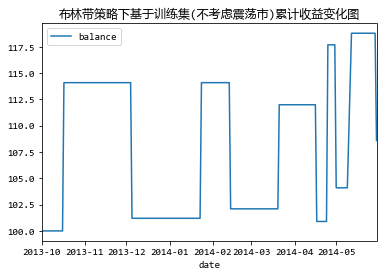

In [85]:
close1.to_csv(r"E:\99_daily\TODAY\close1.csv")
a=close1[['date', 'balance']]
a.set_index(['date']).plot(title="布林带策略下基于训练集(不考虑震荡市)累计收益变化图")

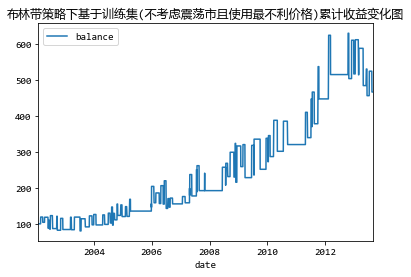

In [74]:
close3.to_csv(r"E:\99_daily\TODAY\close3.csv")
a=close3[['date', 'balance']]
a.set_index(['date']).plot(title="布林带策略下基于训练集(不考虑震荡市且使用最不利价格)累计收益变化图")

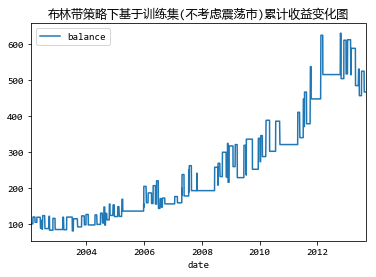

In [27]:
close3.to_csv(r"E:\99_daily\TODAY\close3.csv")
a=close3[['date', 'balance']]
a.set_index(['date']).plot(title="布林带策略下基于训练集(不考虑震荡市)累计收益变化图")

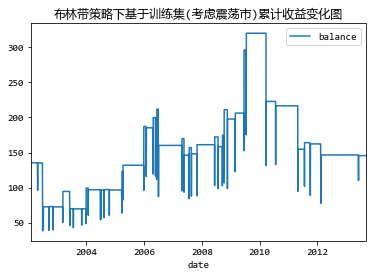

In [25]:
close2.to_csv(r"E:\99_daily\TODAY\close2.csv")
a=close2[['date', 'balance']]
a.set_index(['date']).plot(title="布林带策略下基于训练集(考虑震荡市)累计收益变化图")

In [22]:
a['rr'] = a['balance'] / 100 -1

E:\06_software\Anoconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
close1[(close1.position==0) & (close1.signal != 'No signal')]

,date,close,std,mean,upper,lower,balance,position,signal,amount
46,2013-12-05,69.14,1.163699,69.275714,72.184962,66.366466,101.2,0.0,p,-12.9
94,2014-02-14,68.00,1.817753,67.619524,72.163905,63.075142,102.1,0.0,c,-12.0
137,2014-04-17,64.68,0.677263,64.924286,66.617444,63.231127,100.9,0.0,c,-11.1
146,2014-05-01,64.87,0.709229,64.641905,66.414978,62.868832,104.1,0.0,c,-13.6
166,2014-05-30,73.18,3.226434,68.314762,76.380847,60.248677,108.6,0.0,p,-10.2


In [87]:
close2[(close2.position==0) & (close2.signal != 'No signal')]

,date,close,std,mean,upper,lower,balance,position,signal,amount
79,2014-01-24,67.25,0.829400,70.266190,72.339691,68.192690,100.0,0.0,Long Straddle,-35.6
94,2014-02-14,68.00,1.817753,67.619524,72.163905,63.075142,99.3,0.0,c,-28.0
118,2014-03-21,64.82,0.988152,67.963810,70.434190,65.493429,102.6,0.0,Long Straddle,-21.3
137,2014-04-17,64.68,0.677263,64.924286,66.617444,63.231127,108.2,0.0,c,-25.9
142,2014-04-25,62.83,0.717040,64.781905,66.574504,62.989305,108.6,0.0,Long Straddle,-34.4


In [88]:
close3[(close3.position==0) & (close3.signal != 'No signal')]

,date,close,std,mean,upper,lower,balance,position,signal,amount
46,2013-12-05,69.14,1.163699,69.275714,72.184962,66.366466,101.2,0.0,p,-12.9
94,2014-02-14,68.00,1.817753,67.619524,72.163905,63.075142,102.1,0.0,c,-12.0
137,2014-04-17,64.68,0.677263,64.924286,66.617444,63.231127,100.9,0.0,c,-11.1
146,2014-05-01,64.87,0.709229,64.641905,66.414978,62.868832,103.3,0.0,c,-10.2
166,2014-05-30,73.18,3.226434,68.314762,76.380847,60.248677,107.8,0.0,p,-10.2


In [285]:
(a>0).sum() / len(a)

0.0

In [124]:
a = close1[['date', 'balance', 'signal']].set_index('date')

In [125]:
b=a.drop_duplicates()

In [126]:
len(b)

15

In [123]:
b

,balance,signal
date,,
2013-10-01,100.0,No signal
2013-10-17,114.1,-p
2013-12-05,101.2,p
2013-12-06,101.2,No signal
2014-01-24,114.1,-c
2014-02-14,102.1,c
2014-02-18,102.1,No signal
2014-03-21,112.0,-c
2014-04-17,100.9,c


In [127]:
b

,balance,signal
date,,
2013-10-01,100.0,No signal
2013-10-17,114.1,-p
2013-12-05,101.2,p
2013-12-06,101.2,No signal
2014-01-24,114.1,-c
2014-02-14,102.1,c
2014-02-18,102.1,No signal
2014-03-21,112.0,-c
2014-04-17,100.9,c
